In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

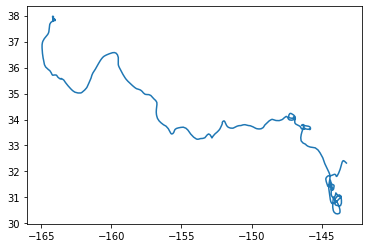

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/oceanhackweek/ohw19-projects-Trackpy/7d62174c4188a0f3d4aaadf848ef91e36da63289/data/example_turtle_track.csv"
track_ex = pd.read_csv(url, parse_dates=['datetime'])
lat_min = track_ex.lat.min()
lat_max = track_ex.lat.max()
lon_min = track_ex.lon.min()
lon_max = track_ex.lon.max()

plt.plot(track_ex.lon,track_ex.lat)

For this tutorial, we will use the Sea Surface Height (SSH) - derived mesoscale eddy product maintained by AVISO. Access to AVISO data products is free, but requires an account. In this step, you will be asked for your AVISO login credentials in order to interact with their mesoscale eddy track database. If you do not have an account, create one here: https://www.aviso.altimetry.fr/en/data/data-access/registration-form.html

In [ ]:
import ftplib
from ftplib import FTP
import getpass

ftp_add =  'ftp-access.aviso.altimetry.fr'

username = input('username:')
password = getpass.getpass()

ftp = FTP(ftp_add)
ftp.login(username,password)
ftp.cwd('value-added/eddy-trajectory/delayed-time/')
filename = 'eddy_trajectory_2.0exp_19930101_20180118.nc'
f = open(filename, "wb")
ftp.retrbinary("RETR " + filename, f.write, 8*1024)
f.close()
ftp.close() 


In [14]:
import xarray as xr

#eddy_ds = xr.open_dataset("eddy_trajectory_2.0exp_19930101_20180118.nc")

lat = eddy_ds.latitude
lon = eddy_ds.longitude
time = eddy_ds.time
cyclonic_type = eddy_ds.cyclonic_type
track = eddy_ds.track
radius = eddy_ds.speed_radius

lon = xr.where(
    lon > 180,
    lon - 360,
    lon)

subset = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)
lat = lat[subset]
lon = lon[subset]
time = time[subset]
cyclonic_type = cyclonic_type[subset]
track = track[subset]
radius = radius[subset]



In [17]:
print(track[0:10])

<xarray.DataArray 'speed_radius' (obs: 10)>
array([124, 121, 119, 121, 111, 116,  98,  96,  94,  87], dtype=uint16)
Dimensions without coordinates: obs
Attributes:
    Longname:     radius_scale
    description:  radius of a circle whose area is equal to that enclosed by ...
    units:        km
    min:          7
    max:          403


In [5]:
import folium
from folium.plugins import TimestampedGeoJson


locations = track_ex[['lat', 'lon']]
locationlist = locations.values.tolist()
len(locationlist)
locationlist[7]

def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'],row['lat']]
            },
            'properties': {
                'time': row['datetime'].date().__str__(),
                'style': {'color' : 'black','weight' : 1, 'opacity' : 0.75},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': 'red',
                    'fillOpacity': 0.5,
                    'stroke': 'true',
                    'radius': 4
                }
            }
        }
        features.append(feature)
    return features

features = create_geojson_features(track_ex)
#features
m = folium.Map(location=[track_ex.lat.mean(), track_ex.lon.mean()], zoom_start=5, tiles=None, control_scale=True)
folium.raster_layers.TileLayer('OpenStreetMap').add_to(m)
folium.raster_layers.TileLayer('stamenterrain').add_to(m)
TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': features}
    , period='P1D'
    , add_last_point=True
    , auto_play=False
    , loop=False
    , max_speed=4
    , loop_button=True
    , date_options='YYYY/MM/DD'
    , time_slider_drag_update=True
    , duration='P2D'
).add_to(m)
feature_group = folium.FeatureGroup(name='Track Line', overlay=True, control=True, show=False)
folium.PolyLine(locationlist,weight=5,color = 'red').add_to(feature_group)
#for point in range(0, len(locationlist)):
#    folium.CircleMarker(locationlist[point],
#                        radius=3,
#                        weight=2, popup=track_ex['datetime'][point]).add_to(m)
folium.plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)
m.add_child(feature_group) 
m.add_child(folium.map.LayerControl())

m

> Creating GeoJSON features...
